In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
hotels = pd.read_csv('hotels_train.csv')
hotels_test = pd.read_csv('hotels_test.csv')
submission = pd.read_csv('submission.csv')

1. Знакомство с данными

In [3]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = hotels_test.append(hotels, sort=False).reset_index(drop=True) # объединяем

C:\Users\Dekstop\AppData\Local\Temp\ipykernel_28972\709043790.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = hotels_test.append(hotels, sort=False).reset_index(drop=True) # объединяем


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [6]:
# Списки с признаками непрерывного типа и признаков типа object
print(data.select_dtypes(np.number).columns.to_list())
print(data.select_dtypes('object').columns.to_list())

['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sample', 'reviewer_score']
['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']


In [7]:
print(f'Количество уникальных названий отелей: {data["hotel_name"].nunique()}\n')

# Даты первого и последнего отзывов
data['review_date'] = pd.to_datetime(data['review_date'])
print(f'Первая и последняя даты отзывов:\n{data["review_date"].agg(["min", "max"])}\n')

# Делаем срез и разделяем теги
tags_list = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))
tags = tags_list.explode(ignore_index=True)
print(f'Количество уникальных тегов: {tags.nunique()}\n')

print(f'Самый частый тег: {tags.mode()[0]}\n')

# С помощью регулярного выражения находим строки с тегом "остановок на ночь"
reg = 'S\w{5}\s\d+\sn\w{4,5}'
night_tags = tags.str.findall(reg).str.get(0)
print(f'Самый частый тег с указанием остановок на ночь: {night_tags.value_counts().index[0]}')

Количество уникальных названий отелей: 1492

Первая и последняя даты отзывов:
min   2015-08-04
max   2017-08-03
Name: review_date, dtype: datetime64[ns]

Количество уникальных тегов: 2428

Самый частый тег: Leisure trip

Самый частый тег с указанием остановок на ночь: Stayed 1 night


2. Очистка данных

In [8]:
#Чистим от дубликатов
data.drop_duplicates(inplace=True)

In [9]:
#Заполняем пустые значения 

import folium
from geopandas.tools import geocode
import numpy as np
from geopy.geocoders import Nominatim #Подключаем библиотеку
geolocator = Nominatim(user_agent="Tester")

address_list = data[data['lat'].isnull()]['hotel_name'].unique().tolist()
df = pd.DataFrame({'hotel_address':address_list})

def get_coords(address, geolocator=geolocator): 
    if geolocator is None:
        geolocator = Nominatim(user_agent="Test")
    ret = geolocator.geocode(address, timeout = 60)
    if ret is None:
        return None
    return ret.latitude, ret.longitude 

# получаем координаты    
df["coords"] = df["hotel_address"].map(get_coords)
df[["lat", "lng"]] = \
    pd.DataFrame(df.pop("coords").tolist(),
                 columns=["lat", "long"], 
                 index=df.index)
    
display(df)

,hotel_address,lat,lng
0,Hotel Atlanta,50.852070,4.354408
1,City Hotel Deutschmeister,NaN,NaN
2,Holiday Inn Paris Montmartre,48.871571,2.343660
3,Fleming s Selection Hotel Wien City,NaN,NaN
4,Hotel City Central,48.213566,16.379921
5,Cordial Theaterhotel Wien,48.209664,16.351426
6,NH Collection Barcelona Podium,41.391882,2.177964
7,Hotel Daniel Vienna,48.188863,16.383852
8,Maison Albar Hotel Paris Op ra Diamond,NaN,NaN
9,Mercure Paris Gare Montparnasse,NaN,NaN


In [10]:
#Переносим предоставленные данные в отдельную переменную и заполняем таблицу известными данными
coordinates = [(50.852070,4.354408),(48.871571,2.343660),(48.213566,16.379921),(48.213566,16.379921),(48.209664,16.351426),(41.391882,2.177964),(48.188863,16.383852
),(48.219675,16.285496),(41.392715,2.167492),(48.186721,16.420653),(49.136466,9.230946),(27.912454,84.883865 )]

for name,coord in zip(address_list,coordinates):
    data.loc[data['hotel_name'] == name, ['lat','lng']] = coord[0], coord[1]

In [11]:
#данные которые не удалось получить заполним медианным значением
import statistics
data['lat'] = data['lat'].fillna(statistics.median(hotels['lat']))
data['lng'] = data['lng'].fillna(statistics.median(hotels['lng']))


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515402 non-null  object        
 1   additional_number_of_scoring                515402 non-null  int64         
 2   review_date                                 515402 non-null  datetime64[ns]
 3   average_score                               515402 non-null  float64       
 4   hotel_name                                  515402 non-null  object        
 5   reviewer_nationality                        515402 non-null  object        
 6   negative_review                             515402 non-null  object        
 7   review_total_negative_word_counts           515402 non-null  int64         
 8   total_number_of_reviews                     515402 non-null  int64        

C:\Users\Dekstop\AppData\Local\Temp\ipykernel_28972\1334919801.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hotels.corr(), annot=True)


<AxesSubplot: >

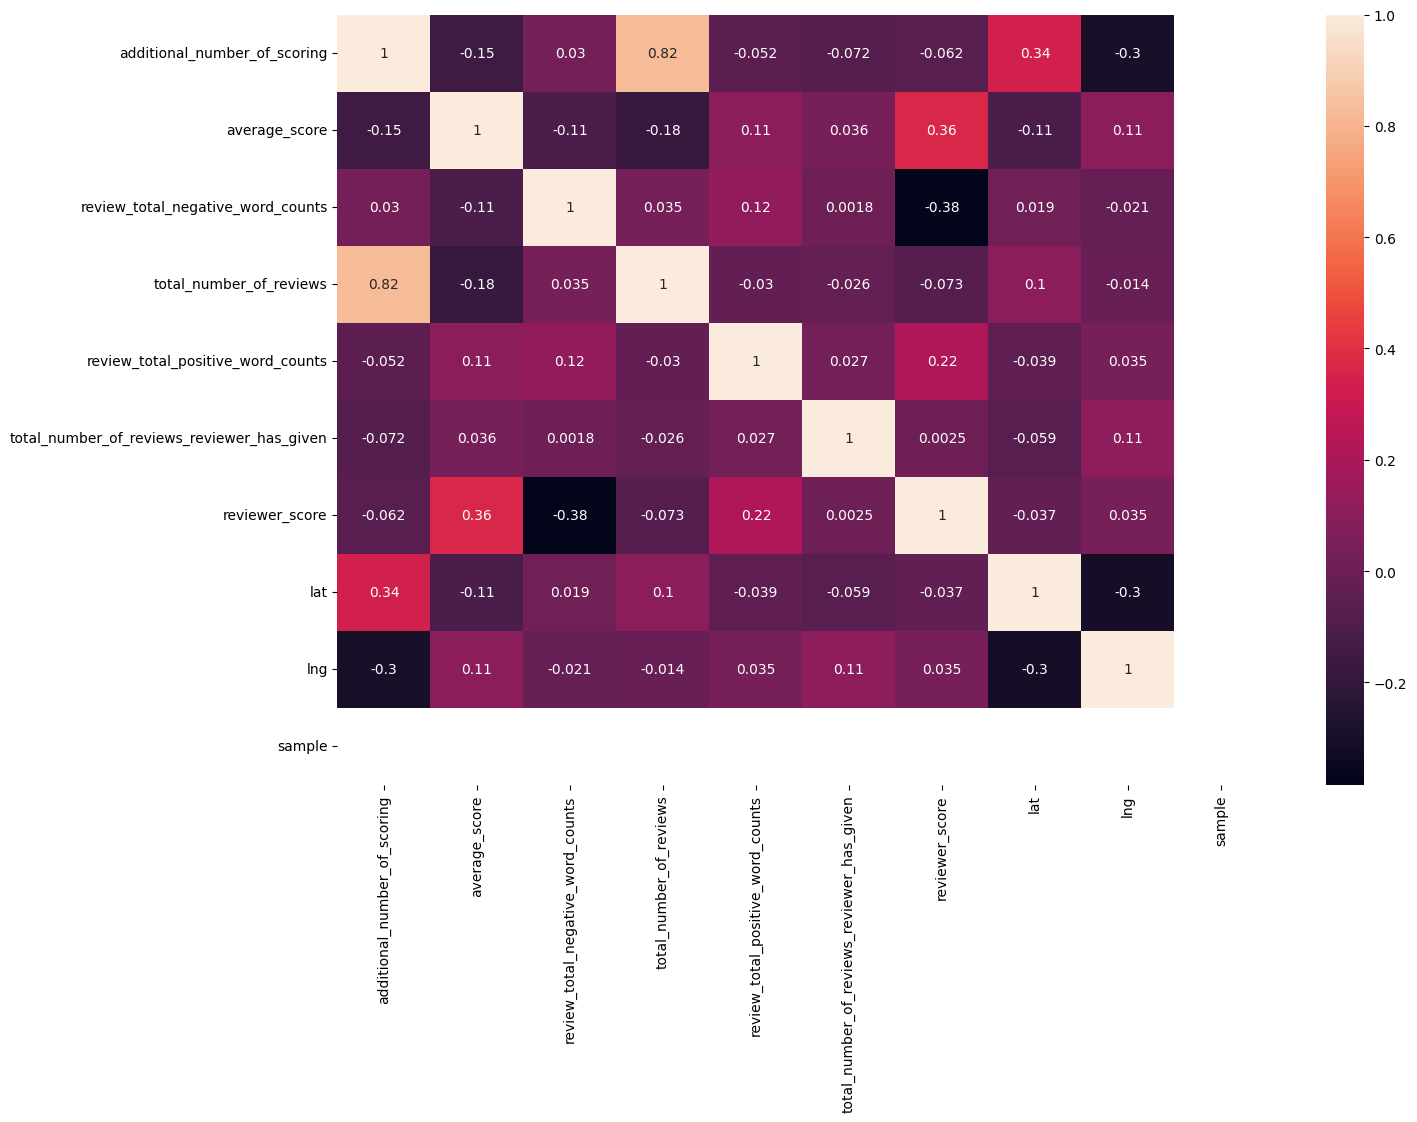

In [13]:
#Так же построим числовую матрицу корреляций чтобы посмотреть в каких значениях нет необходимости
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels.corr(), annot=True)

In [14]:
#так же видим что признак additional_number_of_scoring и total_number_of_reviews имеют сильную корреляцию, избавимся от по моему мнению наименее важному из них
data.drop(columns='additional_number_of_scoring', inplace=True)

3.Создание новых признаков

In [15]:
#Создадим новый признак, город в котором распологается отель
data['city'] = data.hotel_address.apply(lambda x: ''.join(x.split()[-5]) if x.split()[-1] == 'Kingdom' else ''.join(x.split()[-2]))

In [16]:
data['city'].value_counts()#Понимаем что представленные отели расположены в 6 городах

London       262299
Barcelona     60149
Paris         59598
Amsterdam     57212
Vienna        38938
Milan         37206
Name: city, dtype: int64

In [17]:
#Считаю что после того как нам известны города и координаты, отсутствует необходимость в адресе
data.drop(labels='hotel_address',axis=1,inplace=True)

In [18]:
#Посчитаем отношение отрицательных отзывов к положительным
print(round(100 - data[data['city']=='London']['negative_review'].nunique()/data[data['city']=='London']['positive_review'].nunique()*100,2))
print(round(100 - data[data['city']=='Barcelona']['negative_review'].nunique()/data[data['city']=='Barcelona']['positive_review'].nunique()*100,2))
print(round(100 - data[data['city']=='Paris']['negative_review'].nunique()/data[data['city']=='Paris']['positive_review'].nunique()*100,2))
print(round(100 - data[data['city']=='Amsterdam']['negative_review'].nunique()/data[data['city']=='Amsterdam']['positive_review'].nunique()*100,2))
print(round(100 - data[data['city']=='Vienna']['negative_review'].nunique()/data[data['city']=='Vienna']['positive_review'].nunique()*100,2))
print(round(100 - data[data['city']=='Milan']['negative_review'].nunique()/data[data['city']=='Milan']['positive_review'].nunique()*100,2))

16.57
24.4
25.03
21.72
25.44
23.93


In [19]:
#Исходя из данных значений присвоим  обобщённый уровень удовлетворенности городом , своего рода топ 6
def city_rating(city):
    if city == 'London':
        return 6
    elif city == 'Amsterdam':
        return 5
    elif city == 'Milan':
        return 4
    elif city == 'Barcelona':
        return 3
    elif city == 'Paris':
        return 2
    else:
        return 1

In [20]:
data['city_positive_rating'] = data['city'].apply(city_rating)

In [21]:
# Функция выделения дня недели, месяца, года и квартала
def add_datetime_features(df):
    df['review_day_of_week'] = df['review_date'].dt.day_of_week
    df['review_month'] = df['review_date'].dt.month
    df['review_year'] = df['review_date'].dt.year
    return df

# Выделяем день недели, месяц, год и квартал
data = add_datetime_features(data)
data.head(3)

,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,days_since_review,lat,lng,sample,reviewer_score,city,city_positive_rating,review_day_of_week,review_month,review_year
0,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,13 days,45.533137,9.171102,0,0.0,Milan,4,4,7,2017
1,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,234 day,52.385649,4.834443,0,0.0,Amsterdam,5,0,12,2016
2,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,616 day,41.393192,2.161520,0,0.0,Barcelona,3,3,11,2015


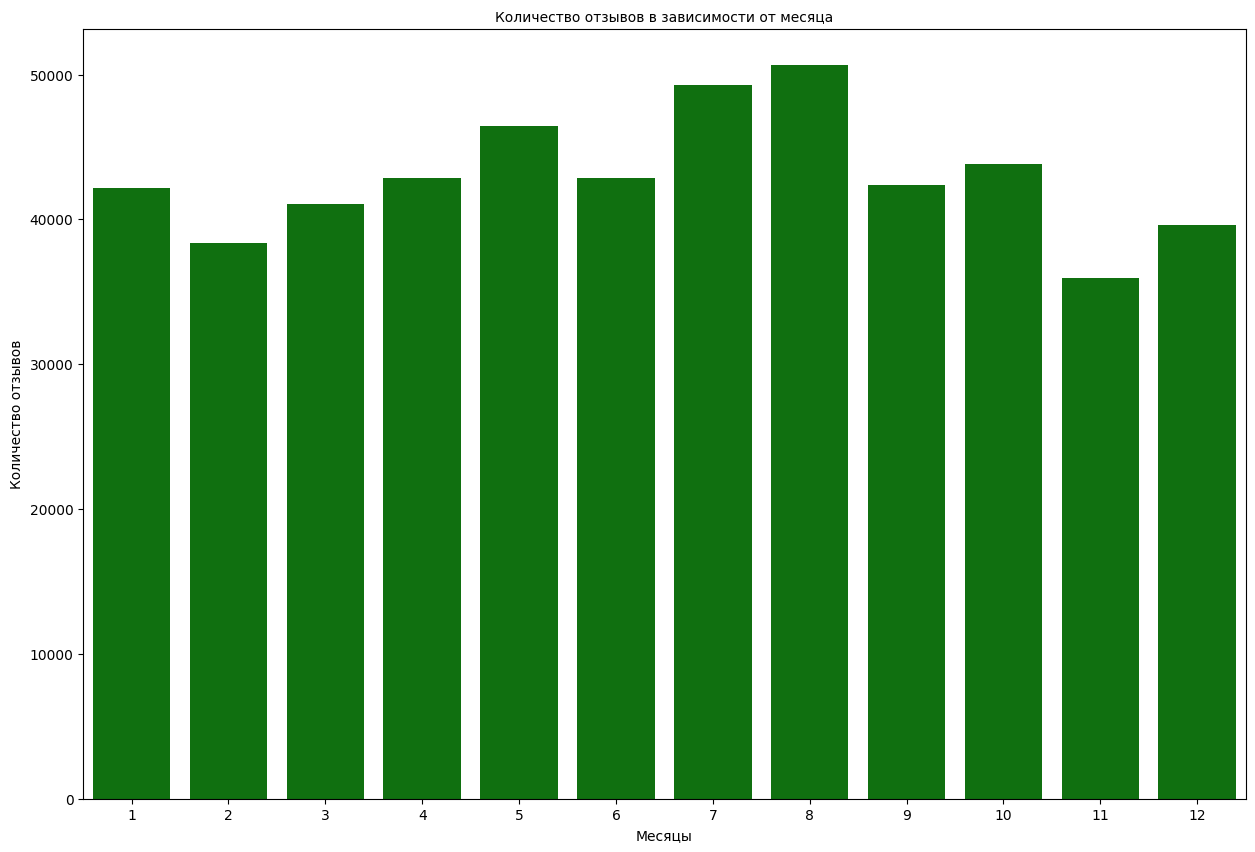

In [22]:
# Рассмотрим распределение количества отзывов от месяца
sns.countplot(x=data['review_month'],color='green')

plt.title('Количество отзывов в зависимости от месяца', fontsize = 10)
plt.xlabel('Месяцы', fontsize = 10)
plt.ylabel('Количество отзывов', fontsize = 10)
plt.show()

Видим что отзывов оставляют больше всего в мае, июле и августе. Так как мы сгенерировали 3 новых признака из 1, у нас отпадает необходимость в признаке review_date.Удаляем его.

In [23]:
data.drop(labels='review_date', axis=1,inplace=True)

Далее преобразуем национальность рецензента, выделим наиболее популярные, остальные сгруппируем.

In [24]:
data['reviewer_nationality'].value_counts().head(10)


 United Kingdom               245158
 United States of America      35385
 Australia                     21662
 Ireland                       14819
 United Arab Emirates          10230
 Saudi Arabia                   8945
 Netherlands                    8762
 Switzerland                    8672
 Germany                        7934
 Canada                         7886
Name: reviewer_nationality, dtype: int64

In [25]:
list_nat = [' United Kingdom ',' United States of America ',' Australia ',' Ireland ',' United Arab Emirates ',' Saudi Arabia ',' Netherlands ',' Switzerland ',' Germany ', ' Canada ']
def pop_nat(nat):
    if nat in list_nat:
        return nat
    else:
        return 'Other'

In [26]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(pop_nat)

In [27]:
data['reviewer_nationality'].value_counts()

 United Kingdom               245158
Other                         145949
 United States of America      35385
 Australia                     21662
 Ireland                       14819
 United Arab Emirates          10230
 Saudi Arabia                   8945
 Netherlands                    8762
 Switzerland                    8672
 Germany                        7934
 Canada                         7886
Name: reviewer_nationality, dtype: int64

In [28]:
#Закодируем получившиеся значения т.к. они номинальные и их меньше 15 используем однократное кодирование
import category_encoders as ce
encoder = ce.OneHotEncoder(cols = ['reviewer_nationality'], use_cat_names=True)
nat_bin = encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data,nat_bin],axis=1)

data


,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,...,reviewer_nationality_Other,reviewer_nationality_ United States of America,reviewer_nationality_ Netherlands,reviewer_nationality_ Ireland,reviewer_nationality_ Canada,reviewer_nationality_ Australia,reviewer_nationality_ Saudi Arabia,reviewer_nationality_ Germany,reviewer_nationality_ United Arab Emirates,reviewer_nationality_ Switzerland
0,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",...,0,0,0,0,0,0,0,0,0,0
1,8.6,Urban Lodge Hotel,Other,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",...,1,0,0,0,0,0,0,0,0,0
2,8.3,Alexandra Barcelona A DoubleTree by Hilton,Other,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",...,1,0,0,0,0,0,0,0,0,0
3,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",...,0,1,0,0,0,0,0,0,0,0
4,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9.0,Hotel Moonlight,Other,No Negative,0,617,Tr s proche du metro Earl s court,10,10,"[' Leisure trip ', ' Group ', ' Club Double or...",...,1,0,0,0,0,0,0,0,0,0
515734,8.4,BEST WESTERN PLUS Amedia Wien,Other,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",...,1,0,0,0,0,0,0,0,0,0
515735,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Singl...",...,0,0,1,0,0,0,0,0,0,0
515736,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",...,0,0,0,0,0,0,0,0,1,0


In [29]:
#Так же закодируем названия отелей, т.к. данный признак номинальный и признаков больше 15 используем двоичное кодирование
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
name_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data,name_bin], axis=1)


In [30]:
print(data.select_dtypes(np.number).columns.to_list())
print(data.select_dtypes('object').columns.to_list())

['average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sample', 'reviewer_score', 'city_positive_rating', 'review_day_of_week', 'review_month', 'review_year', 'reviewer_nationality_ United Kingdom ', 'reviewer_nationality_Other', 'reviewer_nationality_ United States of America ', 'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Ireland ', 'reviewer_nationality_ Canada ', 'reviewer_nationality_ Australia ', 'reviewer_nationality_ Saudi Arabia ', 'reviewer_nationality_ Germany ', 'reviewer_nationality_ United Arab Emirates ', 'reviewer_nationality_ Switzerland ', 'hotel_name_0', 'hotel_name_1', 'hotel_name_2', 'hotel_name_3', 'hotel_name_4', 'hotel_name_5', 'hotel_name_6', 'hotel_name_7', 'hotel_name_8', 'hotel_name_9', 'hotel_name_10']
['hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review', 'city']


In [31]:
#Т.к. модель не может обучаться на категориальных признаках удалим оставшиеся столбцы с такими признаками
data.drop(columns=['hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review', 'city'], inplace=True)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 35 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   average_score                                    515402 non-null  float64
 1   review_total_negative_word_counts                515402 non-null  int64  
 2   total_number_of_reviews                          515402 non-null  int64  
 3   review_total_positive_word_counts                515402 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given       515402 non-null  int64  
 5   lat                                              515402 non-null  float64
 6   lng                                              515402 non-null  float64
 7   sample                                           515402 non-null  int64  
 8   reviewer_score                                   515402 non-null  float64
 9   city_positive_r

4. Отбираем признаки

In [33]:

from sklearn import preprocessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

obj_cols = list(data.select_dtypes('object').columns)
num_cols = list(data.select_dtypes(['int64','float64']).columns)
num_cols.remove('sample')
num_cols.remove('reviewer_score')

data[num_cols].describe()

data_for_norm = data[num_cols]



In [34]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
data_rob = r_scaler.fit_transform(data_for_norm)

# преобразуем промежуточный датасет в полноценный датафрейм
data_rob = pd.DataFrame(data_rob, columns=num_cols)

data_rob.describe()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,city_positive_rating,review_day_of_week,review_month,...,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
count,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,...,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000
mean,-0.003352,0.454281,0.246878,0.398678,0.595017,-0.627654,0.578790,-0.481923,0.180407,-0.102762,...,0.286169,0.390930,0.460243,0.471513,0.486168,0.483007,0.497363,-0.483087,-0.490252,0.485685
std,0.782903,1.413873,0.937649,1.282563,1.576980,1.056595,0.984277,0.586771,0.521096,0.670377,...,0.451970,0.487959,0.498417,0.499188,0.499809,0.499712,0.499994,0.499714,0.499905,0.499796
min,-4.571429,-0.428571,-0.845874,-0.647059,-0.285714,-7.142925,-0.078268,-1.666667,-0.500000,-1.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,-0.428571,-0.333333,-0.393608,-0.352941,-0.285714,-0.995062,-0.032794,-1.000000,-0.250000,-0.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.571429,0.666667,0.606392,0.647059,0.714286,0.004938,0.967206,0.000000,0.750000,0.400000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,2.000000,19.000000,5.880259,22.588235,50.285714,0.272604,17.046619,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000


In [35]:
#Удаляем данные до нормализации и добавляем после
data = data.drop(columns=num_cols)

data = pd.concat([data, data_rob], axis=1)

data.head()

,sample,reviewer_score,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,city_positive_rating,...,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
0,0.0,0.0,-0.428571,2.047619,5.880259,3.000000,-0.285714,-1.806918,1.838204,-0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0
1,0.0,0.0,0.285714,0.047619,1.166667,-0.647059,0.571429,0.268204,0.967100,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
2,0.0,0.0,-0.142857,-0.285714,-0.721278,-0.352941,1.714286,-3.060602,0.430190,-1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0
3,0.0,0.0,1.000000,-0.428571,-0.239078,0.941176,0.857143,-1.823043,1.843265,-0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,0.0,0.0,1.000000,-0.428571,1.032767,-0.235294,-0.142857,0.263630,0.977987,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0


In [36]:
data.drop(obj_cols, axis=1, inplace=True)

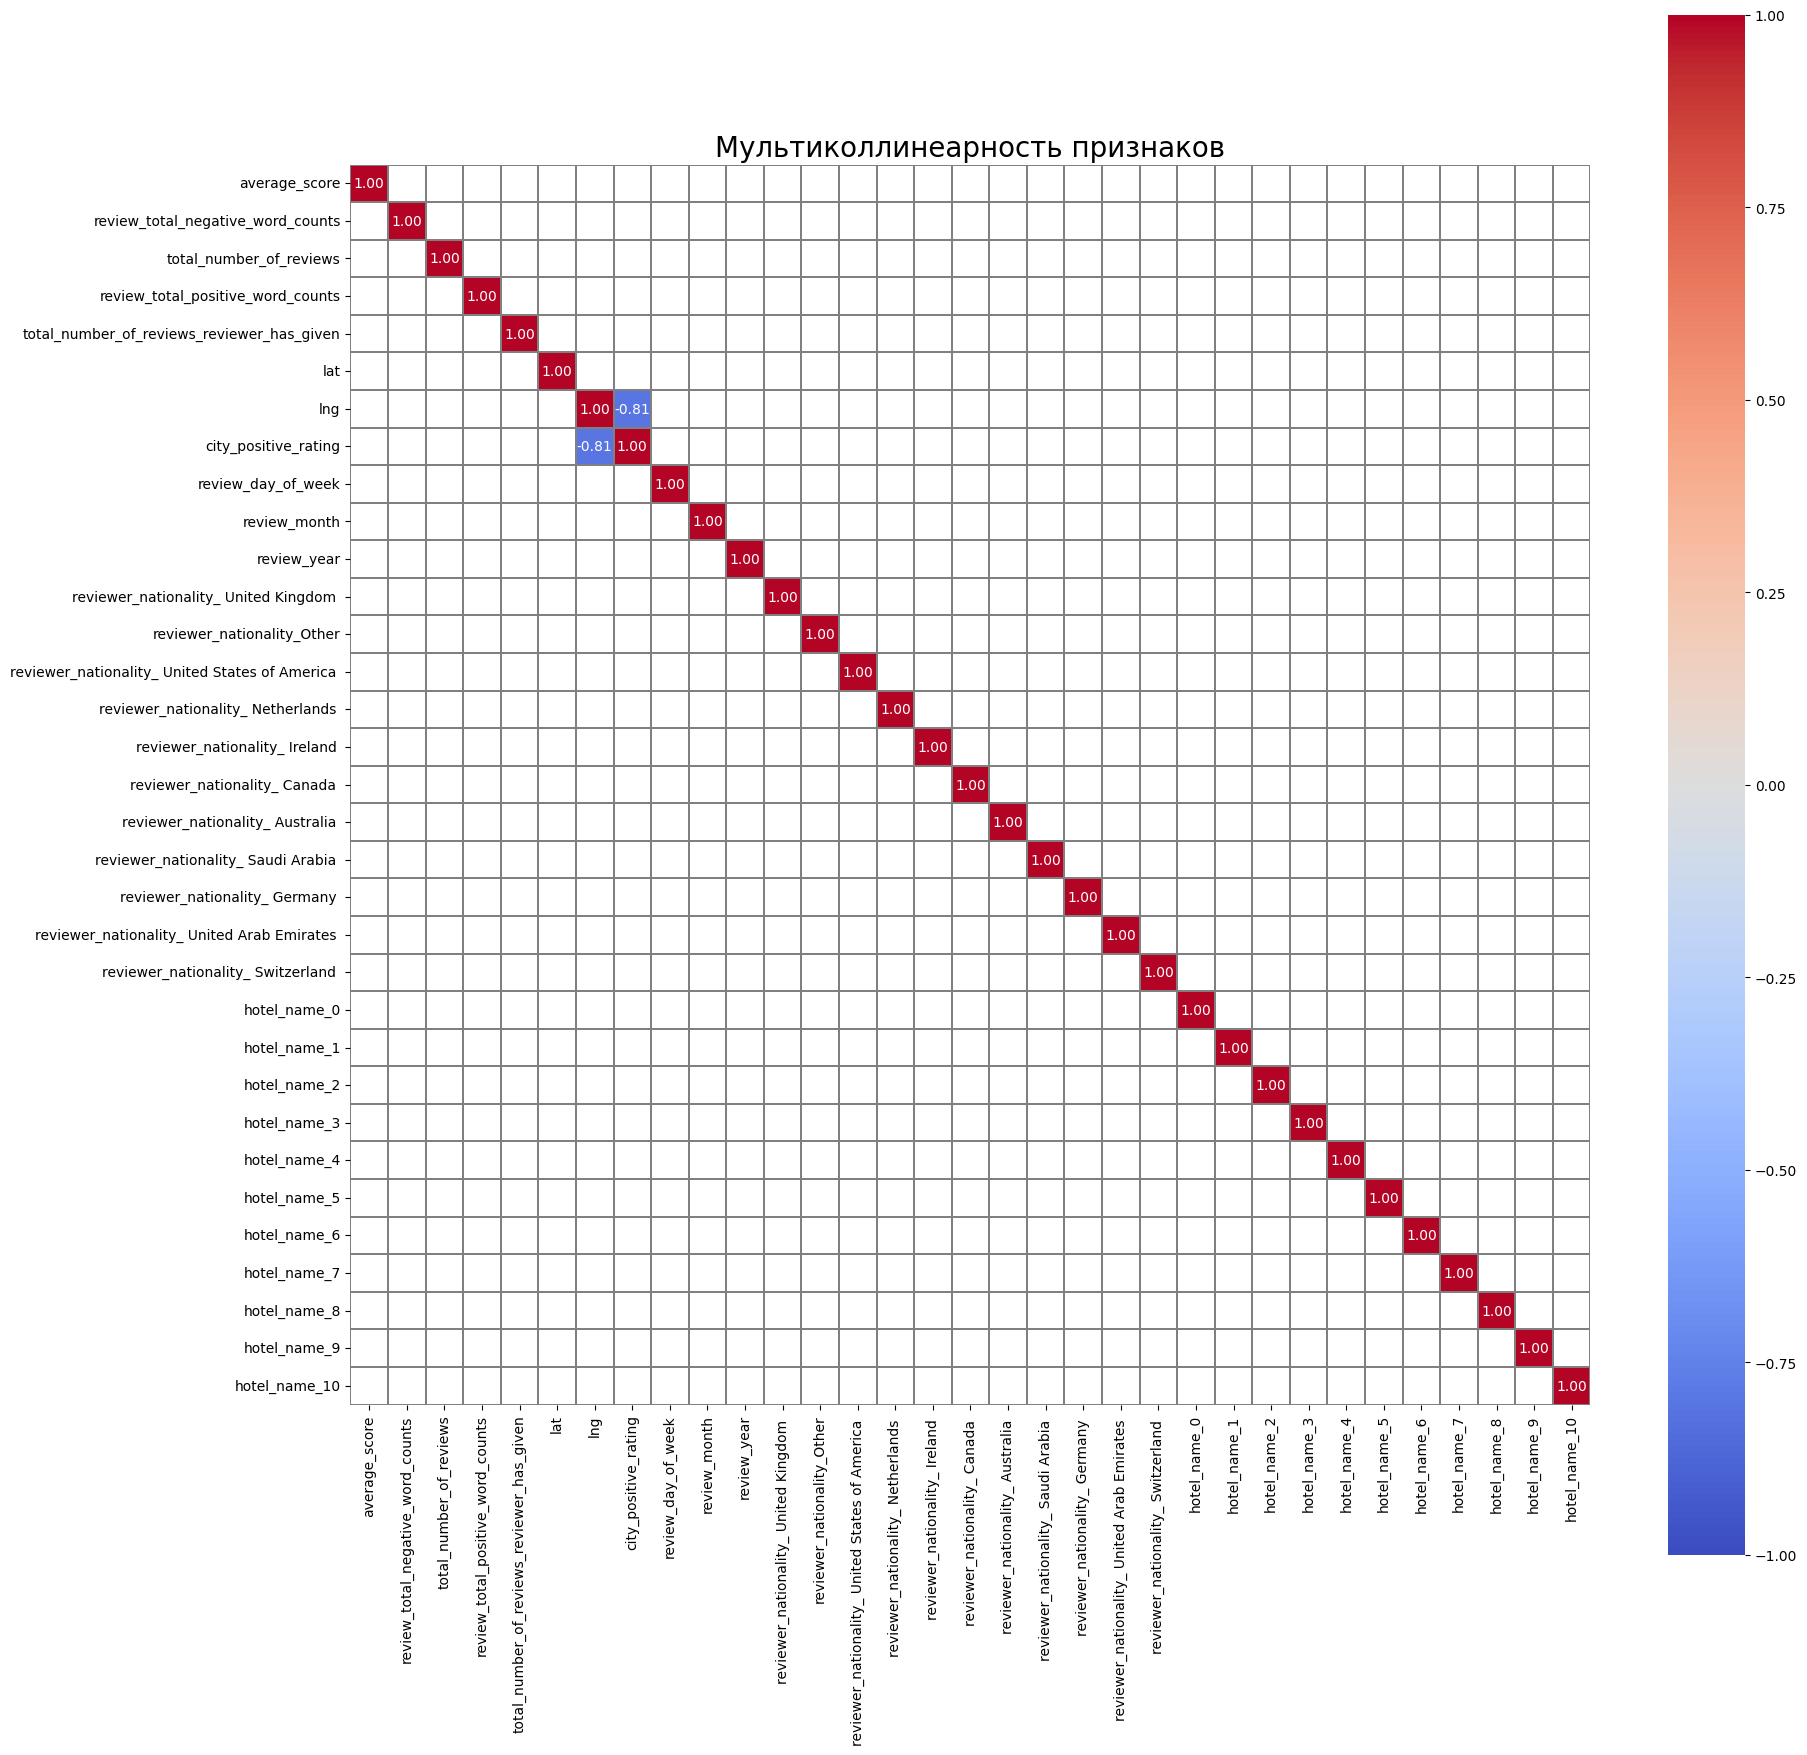

In [37]:
#Проведём оценку мультиколлинеарности признаков 
corr = data.drop(['sample', 'reviewer_score'], axis=1).corr(method='spearman')
plt.subplots(figsize=(20, 20))

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.7
mask_2 = np.abs(corr) <= -0.7
corr_data = corr[mask_1 | mask_2]

# график - тепловая матрица 
figure_2 = sns.heatmap(
    corr_data, 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='coolwarm',
    annot = True,
    fmt='.2f',
    square=True
)

# задаём заголовок
figure_2.set_title('Мультиколлинеарность признаков', fontsize=20);




In [38]:
# определим признаки, между которыми наблюдается сильная связь
for row in corr_data.index:
    for col in corr_data.columns:
        if corr_data.loc[row, col] != 1 and abs(corr_data.loc[row, col]) >= 0.7:
            print(row, col, '-', round(abs(corr_data.loc[row, col]), 3))

lng city_positive_rating - 0.812
city_positive_rating lng - 0.812


Машинный код

In [43]:
data = data.fillna(data.mean())

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

seed = 42
!pip freeze > requirements.txt

In [57]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=seed)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('MAE:', round(metrics.mean_absolute_error(y_test, y_pred), 4))


# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


MAE: 1.3528
MAPE: 0.1968535620581515


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished
